Используя базу "Пассажиры автобуса", подготовьте данные для обучения нейронной сети, классифицирующей изображение на два класса:
- входящий пассажир
- выходящий пассажир

Добейтесь точности работы модели на проверочной выборке не ниже 85%

Ссылка на датасет: https://storage.googleapis.com/terra_ai/DataSets/bus.zip

Информацию о загрузке изображений и преобразовании их в numnpy-массивы вы можете найти в Базе знаний:



---
Дополнительная информация ([База знаний УИИ - «**Загрузка изображений**»](https://colab.research.google.com/drive/1T3i7JL1jYDPZlFT5UwC91cxUL0smehZz?usp=sharing))

---





In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=a6658e5358336700b3bcafd4f48cfda5dbadb37cd6f662643d5a95a27e36cc16
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import numpy as np                              # Библиотека работы с массивами
import pandas as pd                             # Библиотека для работы с таблицами                 

from tensorflow.keras.models import Sequential  # Последовательная модель НС
# Main layers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization  
from tensorflow.keras.layers import Conv2D, MaxPooling2D,  Flatten, Activation 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import image_dataset_from_directory

from tensorflow.keras import utils              # Утилиты предобработки данных
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad   # Оптимизаторы

# Разделение на обучающую и проверочную/тестовую выборку
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt                 # Рисование графиков     

%matplotlib inline

import wget                                     # download file from the link
from zipfile import ZipFile                     # unzip an anrchive
from PIL import Image                           #save images to variables
import cv2                                      #rescale images
import glob
import random
import os

## Download the data

In [ ]:
# download and unzip dataset
url='https://storage.googleapis.com/terra_ai/DataSets/bus.zip'
wget.download(url)

with ZipFile('bus.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [ ]:
# save images to the variable as list
def get_image(path, format='jpg'):
    image_list = []

    for filename in glob.glob(f'{path}/*.{format}', recursive=True):
        im = np.array(
                      load_img(filename,
                               target_size=(250, 250),)
                      ) # color_mode = 'grayscale'
        image_list.append(im)

    return image_list

#your path 
entering_dir = 'data/entering'
getting_off_dir = 'data/getting_off'

#creating a collection with the available images
entering_img = get_image(entering_dir)
getting_off_img = get_image(getting_off_dir)

The image size is (250, 250, 3)


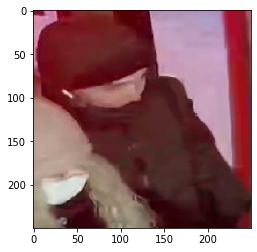

The image size is (250, 250, 3)


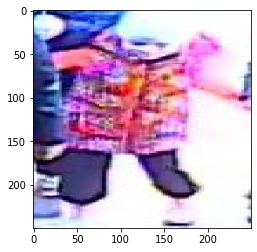

The image size is (250, 250, 3)


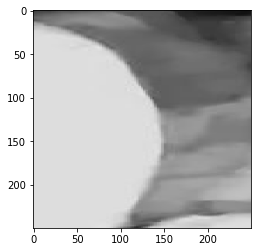

The image size is (250, 250, 3)


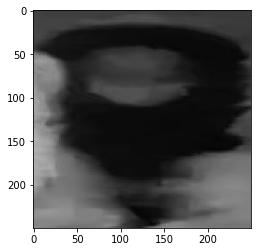

The image size is (250, 250, 3)


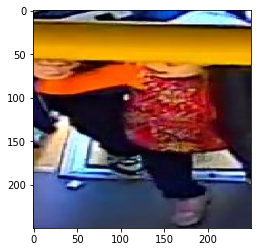

In [ ]:
#check what is inside the dataset
for i in range(len(entering_img[:5])):
    print(f'The image size is {np.array(entering_img[i]).shape}')
    plt.imshow(entering_img[i], )
    plt.show()

## Images' preproccessing

In [ ]:
# def resize_images(images, square_size=250):
#     entering_img_proccessed = []

#     for image in images:
#         # reshape the image
#         res = cv2.resize(np.array(image),
#                          dsize=(square_size, square_size),
#                          interpolation=cv2.INTER_CUBIC)
        
#         #save reshaped image to the list
#         entering_img_proccessed.append(res)

#     return entering_img_proccessed

In [ ]:
# # reshape images in both datasets 
# entering_img_proccessed = resize_images(entering_img)
# getting_off_img_proccessed = resize_images(getting_off_img)

In [ ]:
# # check images after the preproccessing
# for i in range(len(entering_img_proccessed[:5])):
#     print(f'The image size is {np.array(entering_img_proccessed[i]).shape}')
#     plt.imshow(entering_img_proccessed[i])
#     plt.show()

## Prepare train and test samples

In [ ]:
y_entering = [1] * len(entering_img)
y_getting_off = [0] * len(getting_off_img)

### Compare the number of items of each class

In [ ]:
# unbalanced datasets
print(f'Samples for entering the bus are {len(y_entering)}.\n\
Samples for getting off are {len(y_getting_off)}')

Samples for entering the bus are 6485.
Samples for getting off are 2596


In [ ]:
# take 2596 random elements from first list
entering_img = random.sample(entering_img,
                             len(y_getting_off))

y_entering = y_entering[:len(y_getting_off)]

## Combine two datasets in one traing sample

In [ ]:
#concatenate all data in one dataset
x = getting_off_img + entering_img
y = y_getting_off + y_entering

# shuffle x and y datasets in the same order
z = list(zip(x, y))
random.shuffle(z)
x, y = zip(*z)

#transform to numpy array
x = np.array(x)
y = np.array(y)

In [ ]:
val_split = 0.2
X_train, X_val, y_train, y_val = train_test_split(x, y,
                                                  test_size=val_split,
                                                  stratify=y)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(4153, 250, 250, 3) (4153,)
(1039, 250, 250, 3) (1039,)


In [ ]:
y_val

array([1, 0, 1, ..., 1, 0, 1])

In [ ]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
image_gen_train = ImageDataGenerator(rescale=1./255, 
                                     zoom_range=0.2, 
                                     rotation_range=65,
                                     shear_range=0.09,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     ) #validation_split=0.2

image_gen_val = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size=8

train_data_gen = image_gen_train.flow(
                    x=X_train, y=y_train,
                    batch_size=batch_size,
                    shuffle=True,
                   ) # subset='training'

val_data_gen = image_gen_val.flow(
                    x=X_val, y=y_val,
                    batch_size=batch_size,
                    ) #subset='validation'

## Create the model

In [ ]:
def create_model():
    model = Sequential([
    # Note the input shape is the desired size of the image 250x250 with 3 bytes color
    # This is the first convolution
    Conv2D(16, (3,3), activation='relu', input_shape=(250, 250, 3)),
    MaxPooling2D(2, 2),
    # The second convolution
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # The third convolution
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # The fourth convolution
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # # The fifth convolution
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    Flatten(),
    # 512 neuron hidden layer
    Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1
    # where 0 for 1 class ('entering') and 1 for the other ('getting off')
    Dense(1, activation='sigmoid') 
    ])
    return model

In [ ]:
model = create_model()

In [ ]:
#Try to load presaved model's weights
try:
    # Load the Drive helper and mount
    from google.colab import drive
    drive.mount('/content/drive')

    #upload weights from the google drive
    %cp /content/drive/MyDrive/Colab_support/model_weights/getting_off_weights.h5 /content/

    #add weights inside the model
    model.load_weights('getting_off_weights.h5')

    # Re-evaluate the model
    loss, acc = model.evaluate(X_val, y_val, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
    
except:
    pass

In [ ]:
model.compile(loss='binary_crossentropy',
              #choose from Adam, RMSProp, Adagrad
              # default learning_rate = 0.001
              optimizer = Adam(),  
              metrics = 'accuracy')

model.fit(train_data_gen,
          steps_per_epoch=len(train_data_gen)//batch_size,
          validation_data=val_data_gen,
          epochs=200)

Epoch 1/200
65/65 [==============================] - 55s 827ms/step - loss: 0.6963 - accuracy: 0.5269 - val_loss: 0.6842 - val_accuracy: 0.5274
Epoch 2/200
65/65 [==============================] - 55s 854ms/step - loss: 0.6727 - accuracy: 0.5769 - val_loss: 0.8116 - val_accuracy: 0.5525
Epoch 3/200
65/65 [==============================] - 53s 816ms/step - loss: 0.6833 - accuracy: 0.5088 - val_loss: 0.6768 - val_accuracy: 0.5014
Epoch 4/200
65/65 [==============================] - 54s 827ms/step - loss: 0.6852 - accuracy: 0.5269 - val_loss: 0.6766 - val_accuracy: 0.5650
Epoch 5/200
65/65 [==============================] - 53s 824ms/step - loss: 0.6723 - accuracy: 0.5231 - val_loss: 0.6787 - val_accuracy: 0.5409
Epoch 6/200
65/65 [==============================] - 53s 819ms/step - loss: 0.6833 - accuracy: 0.5519 - val_loss: 0.6782 - val_accuracy: 0.5034
Epoch 7/200
65/65 [==============================] - 70s 1s/step - loss: 0.6680 - accuracy: 0.5442 - val_loss: 0.6921 - val_accuracy: 0.

## Save model's weights

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

#checking what are in the folder
path_to_data = '/content/drive/MyDrive/Colab_support/' 
Unique_Labels_List = os.listdir(path_to_data)

Unique_Labels_List

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['digits', 'model_weights']

In [ ]:
#save models weights
model.save_weights('getting_off_weights.h5')

#save models weights to the google drive
%cp /content/getting_off_weights.h5 /content/drive/MyDrive/Colab_support/model_weights/

## Make prediction

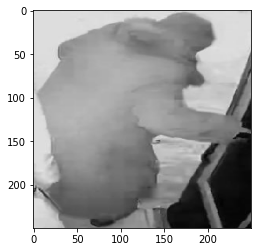

In [ ]:
plt.imshow(X_val[-2] )
plt.show()

In [ ]:
import tensorflow.experimental.numpy as tnp

# Actually I have take a new image for prediction  
# but I took the image from validation dataset
img_array = X_val[-2]
img_array = tnp.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent getting off the bus and %.2f percent entering."
    % (100 * (1 - score), 100 * score)
)

This image is 100.00 percent getting off the bus and 0.00 percent entering.
